# Project 3: Clustering and NLP

## carlos.e.hernandez@<>.com
### Slack: carlosh

# Introduction
	
There are many textual data at Oracle so the ability to work with text is essential. You will build a clustering algorithm that finds similar topics across documents - this is called topic modelling.

An algorithm does not work with text directly but needs to translate it to numbers first. This is typically done by so called TF-IDF transformation. Sometimes you already know classes to which documents belong. Think of an email as a document and spam or non-spam as classes. In that case, you can build a nice Naive Bayes model on top of a TF-IDF matrix. However, in this project we will focus on the unsupervised situation when the classes are not known and they need to be discovered via clustering. Clustering here can be done via the matrix factorisation technique NMF - [see this blog post](https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45) for more details. The task of the project is to discover topics of department of justice press releases.

### Time required
4 weeks	

### Data
https://www.kaggle.com/jbencina/department-of-justice-20092018-press-releases/

# Resources - DELETE ME!

https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45

How NMF actually works
https://medium.com/towards-artificial-intelligence/topic-modeling-with-nmf-for-user-reviews-classification-65913d0b44fe

# Questions

1. Do we have to cluster the whole corpus or should we do a split?
1. How many topics should we aim to extract?


# Environment variables

Make sure to configure these variables to the apropriate locations and to set them prior to executing any import Python statement.

In [ ]:
# Set this variable to wherever you want to download these additional files
%env DATA_LOCATION=/content/drive/MyDrive/Colab Notebooks/Oracle/Assignment3/
#%env DATA_LOCATION=/workspace/datasets/Oracle/Assignment3/
!echo $DATA_LOCATION

# Needed for downloading the NLTK Library Text files
%env NLTK_DATA=/content/drive/MyDrive/Datasets/nltk/
!echo $NLTK_DATA

env: DATA_LOCATION=/content/drive/MyDrive/Colab Notebooks/Oracle/Assignment3/
/content/drive/MyDrive/Colab Notebooks/Oracle/Assignment3/
env: NLTK_DATA=/content/drive/MyDrive/Datasets/nltk/
/content/drive/MyDrive/Datasets/nltk/


# Imports and tools

We'll be using NLTK for NLP, to use it, we first need to install the library proper, and then ask it to download the files and corpus of text needed for its different functionalities.

The Download command will ask for the dataset to download, select:

1. Download
1. `all-corpora`
1. Let the download complete

In [ ]:
import nltk
#nltk.download()
nltk.download("punkt")
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /content/drive/MyDrive/Datasets/nltk/...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /content/drive/MyDrive/Datasets/nltk/...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
%matplotlib inline

import os
import random
import itertools
import re

from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

# Connect to Google Drive if hosting the files there
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
def print_marquee(msg: str):
    """
    Prints a centered message with a marquee of * 
    """
    marquee_width = len(msg) + 4
    print("\n")
    print("*" * marquee_width)
    print(f"* {msg} *")
    print("*" * marquee_width)

# Data

https://www.kaggle.com/jbencina/department-of-justice-20092018-press-releases/

## Context
This is a historical dataset containing 13,087 press releases from the Department of Justice's (DOJ) website https://www.justice.gov/news. The DOJ typically publishes several releases per day and this dataset spans from 2009 to July 2018. The releases contain information such as outcomes of criminal cases, notable actions taken against felons, or other updates about the current administration. This dataset only includes releases categorized as "Press release" and does not contain those which have been labeled as "Speeches". Some releases are tagged with topics or related agencies.

The original Python code to scrape the data can be found on GitHub at https://github.com/jbencina/dojreleases

## Content
The contents are stored as newline delimited JSON records with the following fields:

1. id: Press release number (can be missing if included in contents)
1. title: Title of release
1. contents: Text of release
1. date: Posted date
1. topics: Array of topic tags (if any provided)
1. components: Array of agencies & departments (if any provided)


In [ ]:
data_root_location = os.environ["DATA_LOCATION"]

data = pd.read_json(f"{data_root_location}combined.json",
                    lines=True,
                    convert_dates=["date"])

data.head(5)

,id,title,contents,date,topics,components
0,None,Convicted Bomb Plotter Sentenced to 30 Years,"PORTLAND, Oregon. – Mohamed Osman Mohamud, 23,...",2014-10-01T00:00:00-04:00,[],[National Security Division (NSD)]
1,12-919,$1 Million in Restitution Payments Announced t...,WASHINGTON – North Carolina’s Waccamaw River...,2012-07-25T00:00:00-04:00,[],[Environment and Natural Resources Division]
2,11-1002,$1 Million Settlement Reached for Natural Reso...,BOSTON– A $1-million settlement has been...,2011-08-03T00:00:00-04:00,[],[Environment and Natural Resources Division]
3,10-015,10 Las Vegas Men Indicted \r\nfor Falsifying V...,WASHINGTON—A federal grand jury in Las Vegas...,2010-01-08T00:00:00-05:00,[],[Environment and Natural Resources Division]
4,18-898,$100 Million Settlement Will Speed Cleanup Wor...,"The U.S. Department of Justice, the U.S. Envir...",2018-07-09T00:00:00-04:00,[Environment],[Environment and Natural Resources Division]


## EDA

Let's first figure out the main information of the dataset.

In [ ]:
print_marquee("Data summary:")
display(data.info())

print("\n\nData Description:")
display(data.describe(include="all", datetime_is_numeric=True))



*****************
* Data summary: *
*****************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13087 entries, 0 to 13086
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12810 non-null  object
 1   title       13087 non-null  object
 2   contents    13087 non-null  object
 3   date        13087 non-null  object
 4   topics      13087 non-null  object
 5   components  13087 non-null  object
dtypes: object(6)
memory usage: 613.6+ KB


None



Data Description:


,id,title,contents,date,topics,components
count,12810,13087,13087,13087,13087,13087
unique,12672,12887,13080,2400,253,810
top,13-526,Northern California Real Estate Investor Agree...,,2018-04-13T00:00:00-04:00,[],[Criminal Division]
freq,3,8,2,20,8399,2680


There are some missing IDs, but these don't matter as we'll focus on the title, contents and topics columns and all of these columns don't have empty values. Let's remove the columns that we are not going to use and see the unique values for topics.

In [ ]:
# Remove those columns that we will not use
data_clean_1 = data.copy()
data_clean_1.drop(["id", "date", "components"],
                  axis=1,
                  inplace=True)


unique_topics = set(itertools.chain.from_iterable(data_clean_1["topics"]))
print_marquee(f"Unique topics: {len(unique_topics)}")
display(unique_topics)




*********************
* Unique topics: 42 *
*********************


{'Access to Justice',
 'Antitrust',
 'Asset Forfeiture',
 'Bankruptcy',
 'Civil Rights',
 'Community Outreach',
 'Consumer Protection',
 'Counterintelligence and Export Control',
 'Counterterrorism',
 'Cyber Crime',
 'Disaster Fraud',
 'Drug Trafficking',
 'Elder Justice',
 'Environment',
 'False Claims Act',
 'Financial Fraud',
 'Firearms Offenses',
 'Foreign Corruption',
 'Grants',
 'Hate Crimes',
 'Health Care Fraud',
 'Human Smuggling',
 'Human Trafficking',
 'Identity Theft',
 'Immigration',
 'Indian Country Law and Justice',
 'Intellectual Property',
 'Labor & Employment',
 'Mortgage Fraud',
 'National Security',
 'Office and Personnel Updates',
 'Opioids',
 'Prescription Drugs',
 'Project Safe Childhood',
 'Project Safe Neighborhoods',
 'Public Corruption',
 'Securities, Commodities, & Investment Fraud',
 'Servicemembers Initiative',
 'StopFraud',
 'Tax',
 'Violent Crime',
 'Wildlife'}

Next, we'll want to find the duplicated records, but for that we will first need to make sure that titles and contents are as clean as possible, meaning that we will want to make sure that no extra blank characters are in place and that non-letters characters are removed too.

In [ ]:
# Let's remove all trailing blank space as well as any extra whitespace and
#  non-alphanumeric characters

def clean_text(text: str) -> str:
    # All non-alphanumeric characters except whitespace
    text = re.sub("[^a-zA-Z\s]", " ", text)

    # Extra whitespace is reduced to only one whitespace
    text = re.sub("\s+", " ", text)

    # Remove trailing whitespace
    return text.strip()

data_clean_1["title"] = data_clean_1["title"].map(clean_text)
data_clean_1["contents"] = data_clean_1["contents"].map(clean_text)

Finally, in order to use both the title contents and the content of the article, let's combine these 2 columns into one joined by a simple space. Let's also remove the distinction between cases so as to capture as many duplicated matches as possible.

In [ ]:
data_clean_2 = data_clean_1.copy()

data_clean_2['contents'] = data_clean_2[['title', 'contents']].agg(' '.join,
                                                                   axis=1).str.casefold()

data_clean_2.drop("title", axis=1, inplace=True)

data_clean_2.head(5)

,contents,topics
0,convicted bomb plotter sentenced to years port...,[]
1,million in restitution payments announced to p...,[]
2,million settlement reached for natural resourc...,[]
3,las vegas men indicted for falsifying vehicle ...,[]
4,million settlement will speed cleanup work at ...,[Environment]


We have combined the title and contents columns successfully, let's now determine if we have duplicated values and if we can merge them somehow.

### Duplicated values

We need to answer the following questions:

1. Are there duplicated articles with the same title and contents?
1. Can we merge information from these duplicated rows?

In [ ]:
duplicated_records = data_clean_2[data_clean_2[["contents"]].duplicated(keep=False)]

display(duplicated_records)
print(f"Duplicated records: {duplicated_records.shape[0]}")

,contents,topics
119,akayed ullah charged with terrorism and explos...,[Counterterrorism]
120,akayed ullah charged with terrorism and explos...,[Counterterrorism]
1185,bridgestone corporation agrees to plead guilty...,[]
1186,bridgestone corporation agrees to plead guilty...,[]
1667,clinic owners sentenced for roles in million m...,[]
1668,clinic owners sentenced for roles in million m...,[]
1739,colorado security contractor resolves overchar...,[]
1740,colorado security contractor resolves overchar...,[]
2875,federal agencies announce national initiative ...,"[Access to Justice, Consumer Protection]"
2876,federal agencies announce national initiative ...,[Consumer Protection]


Duplicated records: 38


In [ ]:
# Merge duplicates, making sure to keep their topics
data_clean_3 = data_clean_2.groupby('contents', as_index=False).agg({'contents':'first',
                                                                     'topics': "sum"})

# Make sure that we have unique values in the topics lists
data_clean_3["topics"] = data_clean_3["topics"].map(set).map(list)

display(data_clean_3)

,contents,topics
0,a message from attorney general jeff sessions ...,[]
1,abb ltd and two subsidiaries resolve foreign c...,[]
2,abbott laboratories pays u s million to settle...,[]
3,abbott laboratories sentenced for misbranding ...,[]
4,abbott labs to pay billion to resolve criminal...,[Consumer Protection]
...,...,...
13063,yuengling to upgrade environmental measures to...,[Environment]
13064,zarein ahmedzay pleads guilty to terror violat...,[]
13065,zimmer biomet holdings inc agrees to pay milli...,[Foreign Corruption]
13066,zte corporation agrees to plead guilty and pay...,"[Counterintelligence and Export Control, Asset..."


In [ ]:
data_clean_3[data_clean_3[["contents"]].duplicated(keep=False)]

,contents,topics


We can see now that before we had 38 duplicated records, the final count after merging these records was reduced and we verify that indeed, no more duplicated records exist in our dataset.

### Analyzing unduplicated data


Next, let's figure out how many records contain at least one topic and how many records don't have any topic.

In [ ]:
records_with_topics = data_clean_3[data_clean_3['topics'].map(lambda t: bool(t))]
records_without_topics = data_clean_3[data_clean_3['topics'].map(lambda t: not bool(t))]

print(f"Records with at least 1 topic: {records_with_topics.shape[0]}\nRecords with no topics: {records_without_topics.shape[0]}\n")

Records with at least 1 topic: 4685
Records with no topics: 8383



Most of the data doesn't have any topic assigned to it. This is the partition that we will use for the training.

Now, let's get some statistics on the length of the contents, we want to know if most of the records have enough data for the training. For this, we'll do a simple parsing of unigrams to see how many words there are.

In [ ]:
def count_words_in_text(x: str) -> int:
    return len(x.split())

print_marquee("Word count")

print_marquee("Whole dataset")
general_word_count = data_clean_3["contents"].map(count_words_in_text).to_frame()
display(general_word_count.describe())

print_marquee("Training set (Records with topics):")
display(records_with_topics["contents"].map(count_words_in_text).to_frame().describe())

print_marquee("Test set (Records without topics):")
display(records_without_topics["contents"].map(count_words_in_text).to_frame().describe())




**************
* Word count *
**************


*****************
* Whole dataset *
*****************


,contents
count,13068.000000
mean,594.774411
std,485.301182
min,8.000000
25%,365.000000
50%,510.000000
75%,709.250000
max,21632.000000




***************************************
* Training set (Records with topics): *
***************************************


,contents
count,4685.000000
mean,623.746211
std,539.200341
min,41.000000
25%,380.000000
50%,527.000000
75%,740.000000
max,17334.000000




**************************************
* Test set (Records without topics): *
**************************************


,contents
count,8383.000000
mean,578.582966
std,451.615180
min,8.000000
25%,357.000000
50%,503.000000
75%,692.000000
max,21632.000000


contents    AxesSubplot(0.125,0.536818;0.352273x0.343182)
dtype: object

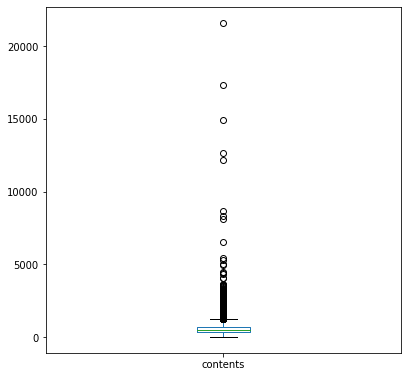

In [ ]:
general_word_count.plot.box(subplots=True,
                            layout=(2, 2),
                            figsize=(14,14))

We can see that all records have at least 8 words and that most records have around 500 words. There are many outliers with different text lengths, but let's keep them for now.

Let's take a look at the top 20 words in the whole corpus.

In [ ]:
cv = CountVectorizer()
cv_fit = cv.fit_transform(data_clean_3["contents"])

word_list = cv.get_feature_names();    
count_list = cv_fit.toarray().sum(axis=0) 

word_counter = pd.DataFrame(dict(zip(word_list,count_list)).items(),
                            columns=["word", "count"])

word_counter = word_counter.sort_values(
    by=["count"],
    ascending=False)

display(word_counter.head(20))

,word,count
50707,the,485067
36122,of,296754
2120,and,286015
51182,to,247421
24492,in,184172
19137,for,92682
50700,that,72662
55537,with,54954
7151,by,53309
13358,department,48393


We see that the words that are repeated the most are mostly prepositions. This is what is called a STOP WORD and while they are the most common type of word in a corpus of text, because of that exact reason, they do not provide contextual meaning to our descriptions. We should remove them from the corpus on which we will train our model.

Let's try again but this time we'll remove the STOP_WORDS. A word of caution though, SciKit-Learn discourages the use of its stop words list in production environments due to unexpected behaviors in real-world scenarios. For our model we'll use the NLTK stop word list.

In [ ]:
cv = CountVectorizer(stop_words="english")
cv_fit = cv.fit_transform(data_clean_3["contents"])

word_list = cv.get_feature_names();    
count_list = cv_fit.toarray().sum(axis=0) 

word_counter = pd.DataFrame(dict(zip(word_list,count_list)).items(),
                            columns=["word", "count"])

word_counter = word_counter.sort_values(
    by=["count"],
    ascending=False)

display(word_counter.head(20))

,word,count
13297,department,48393
3503,attorney,46587
26682,justice,37888
14469,district,35604
14529,division,32210
20214,general,25921
49960,tax,24317
19372,fraud,23825
11603,criminal,23704
35978,office,23082


This is a list that makes more sense, we see that a lot of the words seem to be related to crimes or law enforcement which makes sense given the source of the dataset.

### Insights

We were able to transform the data in the appropriate shape so that we could remove all of the duplicated records, we were also able to see that the training set has a sizable amount of characters which should let us extract significant tokens out of them.

Extracting the most common words gives us just a partial picture of its importance, after all, if all articles contain some word, it may not give us a lot of information on what particular topic an article is talking about. For that we may want to calculate its TF-IDF score which gives a bigger score to the terms that appear seldomly and penalizes the tokens that appear more often across the corpus.

# Preparing the data for model ingestion

Now that we have cleaned up the data, we need to prepare it for the actual model ingestion. We are presented with different challenges here, for example, consider the words `flying` `flew` `fly`, while they use different tenses, they probably convey the same general meaning, we need to standardized this into a manner where the model isn't concerned about this. The process for doing this is called **lemmatization**. Another technique is called **stemming** which reduces a set of words to their common stem, usually by trimming the words.

Lemmatization takes into account the actual meaning of the word, giving more accurate reductions; this means that calculating the lemmas of the words are generally computationally expensive to calculate.

Stemming, on the other hand, may not be as precise (`caring`'s lemma --> `care`; `caring`'s stem --> `car` which is not accurate), but it is usually faster to calculate.

In [ ]:
modeling_data = data_clean_3.copy()

def preprocess_text_for_model(text: str) -> str:

    stop_words = set(nltk.corpus.stopwords.words('english'))
    stemmer = SnowballStemmer("english")

    # Tokenize each of the words
    tokens = word_tokenize(text)

    # Remove all stop words and reduce them to its stem (not to be confused with lemma!)
    tokens = [stemmer.stem(t) for t in tokens if t not in stop_words]

    # Remove all tokens of length 1
    tokens = [t for t in tokens if len(t) > 1]
    
    # Return the tokens to text form as we'll use a different tokenizing techinque
    #  for the TF-IDF tokenizer
    return " ".join(tokens)

modeling_data["contents"] = modeling_data["contents"].map(preprocess_text_for_model)

modeling_data["contents"].head(3)

0    messag attorney general jeff session impact hu...
1    abb ltd two subsidiari resolv foreign corrupt ...
2    abbott laboratori pay million settl claim comp...
Name: contents, dtype: object

## Train/Test Split

In this project, we are using unsupervised learning to detect the topics inside the texts, so the topics column that we already have will not be used for training, but it will be interesting to see how much the model approaches the
human-made topics.

We'll use a randomized 80/20 split for the training and testing.


In [ ]:
train_set, test_set = train_test_split(modeling_data,
                                       train_size=0.8,
                                       random_state=42)

print(f"Train set size: {train_set.shape}")
print(f"Test set size: {test_set.shape}")

Train set size: (10454, 2)
Test set size: (2614, 2)


In [ ]:
train_set.head(10)

,contents,topics
1523,children hospit pay million settl fals claim a...,[False Claims Act]
4139,former los angel area pastor sentenc role mill...,[]
1110,border patrol agent plead guilti civil right v...,[]
10725,sorensen gross construct co corpor vice presid...,[False Claims Act]
1406,canadian man plead guilti conspir defraud unit...,[Tax]
7607,justic depart monitor elect maricopa counti ar...,[]
6651,justic depart reach agreement citi williamsbur...,[]
4742,former ub banker charg help taxpay use secret ...,[]
12658,upstat new york man convict role attempt devel...,[]
10480,second caesar palac nightclub host plead guilt...,[]


# Models TBD

In [ ]:
train_tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 2)
)

train_tfidf = train_tfidf_vectorizer.fit_transform(train_set['contents'])

topic_model = NMF(
    n_components=42,
    init='nndsvd'
).fit(train_tfidf)

In [ ]:
tfidf_feature_names = train_tfidf_vectorizer.get_feature_names()

In [ ]:
print(topic_model.components_)

[[0.         0.         0.00617771 ... 0.         0.         0.12197642]
 [0.         0.00055844 0.         ... 0.         0.         0.        ]
 [0.00627574 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.00128065 0.         ... 0.         0.         0.16828242]
 [0.         0.         0.00358034 ... 0.18921652 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [ ]:
def get_top_topics_for_documents(model, feature_names, max_words_per_topic: int = 20) -> dict:

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-max_words_per_topic - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        print_marquee(f"Topic: {topic_idx}")
        print(top_features_ind)
        print(top_features)
        print(weights)
    
get_top_topics_for_documents(topic_model, tfidf_feature_names, 20)



************
* Topic: 0 *
************
[4482 2599 2440 4494 2442 3935 4484 1801 1907 1914 1605 1787 3949 2602
 2555 1707 4485 3429 4178 4977]
['tax', 'ir', 'incom', 'tax return', 'incom tax', 'return', 'tax divis', 'fals', 'file', 'file fals', 'employ tax', 'fail', 'revenu', 'ir crimin', 'intern revenu', 'evas', 'tax evas', 'pay', 'servic ir', 'year']
[8.63527147 3.86000812 2.72820559 2.25075993 1.74186224 1.70573467
 1.63507316 1.52968286 1.3967605  1.2788204  1.07215928 1.0578175
 0.99670165 0.97421596 0.9679455  0.95369354 0.94714155 0.90478135
 0.87581379 0.85381342]


************
* Topic: 1 *
************
[4482 3570 3935 4494 2508 3944 4491 1178  910 3573 1123 1883  591 3580
 3464  449 2440 1238  794 1856]
['tax', 'prepar', 'return', 'tax return', 'injunct', 'return prepar', 'tax prepar', 'custom', 'complaint', 'prepar feder', 'credit', 'feder tax', 'busi', 'prepar tax', 'perman', 'bar', 'incom', 'deduct', 'claim', 'feder']
[1.93732541 1.5657841  0.94081601 0.75466247 0.6021492

We can see that the model is creating the clusters where the top topics have a topic in common, for example, for those documents where `tax return, prepar tax, feder tax` are the most common tokens is because they are probably related with tax preparation or tax return fraud.

We can make a similar assumption for Topic 2 that has `hhs, medicar fraud` that may be related to medicare fraud, or Topic 6 where the tokens point to gang violence.

We could go ahead and have a human infer all of the topics and create distinct categories so that new documents are automatically labeled. We've seen that after preparing the text, removing characters and stop words and stemming, the model is working pretty well for what we were looking for here.

In [ ]:
plot_top_words(topic_model, tfidf_feature_names, 20,
               'Topics in NMF model (generalized Kullback-Leibler divergence)')

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()